**The Vision Transformer (ViT)**

is a model that applies the Transformer architecture, originally designed for natural language processing (NLP), to image classification tasks. Below is a detailed step-by-step explanation of what happens in a ViT model from the moment an image is input until the final class prediction is made:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Input Image
The input to the ViT is a 2D image, typically with dimensions
H
×
W
×
C
H×W×C, where:

H
H is the height of the image.

W
W is the width of the image.

C
C is the number of channels (e.g., 3 for RGB images).

# 2. Patch Embedding
The image is divided into fixed-size patches. Each patch has dimensions
P
×
P
×
C
P×P×C, where
P
P is the patch size.

For example, if the input image is
224
×
224
×
3
224×224×3 and
P
=
16
P=16, the image is divided into
224
16
×
224
16
=
14
×
14
=
196
16
224
​
 ×
16
224
​
 =14×14=196 patches.

Each patch is flattened into a 1D vector of size
P
×
P
×
C
=
16
×
16
×
3
=
768
P×P×C=16×16×3=768.

These flattened patches are then projected into a higher-dimensional embedding space using a learnable linear projection (a fully connected layer). This results in patch embeddings of size
D
D, where
D
D is the embedding dimension (e.g., 768).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        # Linear projection to embed patches
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # Input shape: (batch_size, in_channels, img_size, img_size)
        x = self.proj(x)  # Shape: (batch_size, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x = x.flatten(2)  # Shape: (batch_size, embed_dim, n_patches)
        x = x.transpose(1, 2)  # Shape: (batch_size, n_patches, embed_dim)
        return x



**Multi-Head Self-Attention (MSA):**

The input embeddings are split into multiple "heads," and self-attention is computed independently for each head.

Self-attention allows the model to weigh the importance of different patches relative to each other.

The outputs of all heads are concatenated and linearly projected back to the original embedding dimension D D.

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.shape

        # Linear projections for Q, K, V
        Q = self.query(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled Dot-Product Attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        # Apply attention to values
        out = torch.matmul(attn, V)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)

        # Final linear layer
        out = self.out(out)
        return out



# 5. Transformer Encoder
The sequence of embeddings (including the [CLS] token) is passed through a standard Transformer encoder, which consists of multiple layers of multi-head self-attention and feed-forward neural networks.

Each Transformer encoder layer performs the following steps:

**Multi-Head Self-Attention (MSA):**

The input embeddings are split into multiple "heads," and self-attention is computed independently for each head.

Self-attention allows the model to weigh the importance of different patches relative to each other.

The outputs of all heads are concatenated and linearly projected back to the original embedding dimension
D
D.

**Layer Normalization (LN):**

Normalization is applied to stabilize training.

**Feed-Forward Network (FFN):**

A two-layer MLP (multilayer perceptron) with a non-linear activation (e.g., GELU) is applied to each embedding independently.

**Residual Connections:**

Residual connections are added around both the MSA and FFN blocks to help with gradient flow and training stability.



In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, mlp_dim=3072, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # Self-attention with residual connection
        x = x + self.attn(self.norm1(x))
        # MLP with residual connection
        x = x + self.mlp(self.norm2(x))
        return x



# 3. Adding Positional Embeddings
Since Transformers are permutation-invariant (they do not inherently understand the order of inputs), positional embeddings are added to the patch embeddings to retain spatial information.

The positional embeddings are learnable vectors of size
D
D that encode the position of each patch in the original image.

The patch embeddings and positional embeddings are added element-wise, resulting in a sequence of embeddings that now contain both patch content and positional information.

# 4. Prepend [CLS] Token
A special learnable token, called the [CLS] token, is prepended to the sequence of patch embeddings.

The [CLS] token is a vector of size
D
D that will aggregate information from all patches during the Transformer's self-attention process.

The purpose of the [CLS] token is to serve as a representation of the entire image for classification.

# 5. Transformer Encoder

# 6. [CLS] Token Extraction
After passing through all Transformer encoder layers, the final output corresponding to the [CLS] token is extracted.

This [CLS] token embedding now contains a global representation of the entire image, as it has aggregated information from all patches through the self-attention mechanism.

# 7. Classification Head
The [CLS] token embedding is passed through a classification head, which is typically a small MLP (e.g., a single fully connected layer followed by a softmax activation).

The output of the classification head is a probability distribution over the possible classes.

# 8. Class Prediction
The class with the highest probability is selected as the final prediction.

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=5, embed_dim=768, depth=12, num_heads=12, mlp_dim=3072, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_dim, dropout) for _ in range(depth)
        ])

        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # Patch embedding
        x = self.patch_embed(x)  # Shape: (batch_size, n_patches, embed_dim)

        # Add [CLS] token
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)  # Shape: (batch_size, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1)  # Shape: (batch_size, n_patches + 1, embed_dim)

        # Add positional embeddings
        x = x + self.pos_embed
        x = self.dropout(x)

        # Pass through Transformer blocks
        for block in self.blocks:
            x = block(x)

        # Extract [CLS] token
        x = self.norm(x)
        cls_token_final = x[:, 0]  # Shape: (batch_size, embed_dim)

        # Classification head
        logits = self.head(cls_token_final)  # Shape: (batch_size, num_classes)
        return logits



In [ ]:
# Example usage
if __name__ == "__main__":
    img = torch.randn(1, 3, 224, 224)  # Input image (batch_size=1, channels=3, height=224, width=224)
    model = VisionTransformer(num_classes=5)
    output = model(img)
    print(output.shape)  # Expected shape: (1, 1000)

torch.Size([1, 1000])


# Train the model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import os
import pandas as pd



## Callbacks

In [ ]:

class ModelCheckpoint:
    def __init__(self, filepath, monitor='val_loss', mode='min'):
        self.filepath = filepath
        self.best_metric = float('inf') if mode == 'min' else -float('inf')
        self.monitor = monitor
        self.mode = mode

    def step(self, current_metric, model):
        if (self.mode == 'min' and current_metric < self.best_metric) or \
           (self.mode == 'max' and current_metric > self.best_metric):
            self.best_metric = current_metric
            torch.save(model.state_dict(), self.filepath)

class ReduceLROnPlateau:
    def __init__(self, optimizer, patience=3, factor=0.1, monitor='val_loss', mode='min'):
        self.optimizer = optimizer
        self.patience = patience
        self.factor = factor
        self.monitor = monitor
        self.mode = mode
        self.wait = 0
        self.best_metric = float('inf') if mode == 'min' else -float('inf')

    def step(self, current_metric):
        if (self.mode == 'min' and current_metric < self.best_metric) or \
           (self.mode == 'max' and current_metric > self.best_metric):
            self.best_metric = current_metric
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] *= self.factor
                self.wait = 0

class EarlyStopping:
    def __init__(self, patience=5, monitor='val_loss', mode='min'):
        self.patience = patience
        self.monitor = monitor
        self.mode = mode
        self.best_metric = float('inf') if mode == 'min' else -float('inf')
        self.wait = 0

    def step(self, current_metric):
        if (self.mode == 'min' and current_metric < self.best_metric) or \
           (self.mode == 'max' and current_metric > self.best_metric):
            self.best_metric = current_metric
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                return True
        return False

class CSVLogger:
    def __init__(self, filepath):
        self.filepath = filepath
        self.logs = []

    def log(self, epoch, metrics):
        metrics['epoch'] = epoch
        self.logs.append(metrics)
        pd.DataFrame(self.logs).to_csv(self.filepath, index=False)



## 1. Data Preparation

In [ ]:

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Random crop
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Flowers_Divided/train', transform=train_transform)
val_dataset = datasets.ImageFolder('/content/drive/MyDrive/Flowers_Divided/val', transform=val_test_transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Flowers_Divided/test', transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



## 2. Model Preparation

In [ ]:

model = VisionTransformer(num_classes=5)  # 5 categories
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
# Use the PyTorch ReduceLROnPlateau scheduler instead of the custom one
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Flowers_Divided/VIT_pytorch_model.pth', monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
early_stopping = EarlyStopping(patience=10, monitor='val_loss', mode='min')
logger = CSVLogger('training_log.csv')



## 3. Training Loop

In [ ]:


num_epochs = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    train_correct = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
    train_acc = train_correct / len(train_dataset)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
    val_acc = val_correct / len(val_dataset)

    # Logging
    metrics = {'train_loss': train_loss / len(train_loader), 'val_loss': val_loss / len(val_loader),
               'train_acc': train_acc, 'val_acc': val_acc}
    logger.log(epoch, metrics)
    print(f"Epoch {epoch + 1}/{num_epochs} - {metrics}")

    # Callbacks
    checkpoint.step(metrics['val_loss'], model)
    reduce_lr.step(metrics['val_loss'])
    if early_stopping.step(metrics['val_loss']):
        print("Early stopping triggered!")
        break




Epoch 1/100 - {'train_loss': 1.7380208432674409, 'val_loss': 1.3787483437494799, 'train_acc': 0.2965085982282439, 'val_acc': 0.4198250728862974, 'epoch': 0}
Epoch 2/100 - {'train_loss': 1.414516019821167, 'val_loss': 1.2971978133374995, 'train_acc': 0.37415320479416364, 'val_acc': 0.4518950437317784, 'epoch': 1}
Epoch 3/100 - {'train_loss': 1.3492795010407765, 'val_loss': 1.2128832827914844, 'train_acc': 0.4043772798332465, 'val_acc': 0.48250728862973763, 'epoch': 2}
Epoch 4/100 - {'train_loss': 1.300568734606107, 'val_loss': 1.107783555984497, 'train_acc': 0.46638874413757164, 'val_acc': 0.565597667638484, 'epoch': 3}
Epoch 5/100 - {'train_loss': 1.2618435045083365, 'val_loss': 1.1567518995566801, 'train_acc': 0.46534653465346537, 'val_acc': 0.5276967930029155, 'epoch': 4}
Epoch 6/100 - {'train_loss': 1.2230530301729838, 'val_loss': 1.1864351413466714, 'train_acc': 0.49713392391870764, 'val_acc': 0.49854227405247814, 'epoch': 5}
Epoch 7/100 - {'train_loss': 1.2429352045059203, 'val_lo

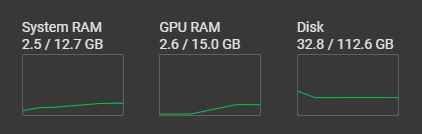

## 4. Testing

In [ ]:

model.load_state_dict(torch.load('/content/drive/MyDrive/Flowers_Divided/VIT_pytorch_model.pth'))
model.eval()
test_correct = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = test_correct / len(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

<ipython-input-24-4b01eaa8eaba>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Flowers_Divided/VIT_pytorch_model.p

Test Accuracy: 0.6667


# Pre-trained Vision Transformer (ViT)

In [22]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
import os
from sklearn.metrics import classification_report, accuracy_score

In [25]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths to the dataset
data_dir = "/content/drive/MyDrive/Flowers_Divided"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 1e-4

In [26]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Datasets and Dataloaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
# Training and validation loop
best_val_acc = 0.0
best_model_path = "/content/drive/MyDrive/Flowers_Divided/Pretrained_vit_model.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values=images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images).logits
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.4f}")

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print("Best model saved.")


Epoch [1/10], Loss: 0.0431
Validation Accuracy: 0.9708
Best model saved.
Epoch [2/10], Loss: 0.0431
Validation Accuracy: 0.9708
Epoch [3/10], Loss: 0.0431
Validation Accuracy: 0.9708
Epoch [4/10], Loss: 0.0431
Validation Accuracy: 0.9708
Epoch [5/10], Loss: 0.0431
Validation Accuracy: 0.9708
Epoch [6/10], Loss: 0.0431
Validation Accuracy: 0.9708
Epoch [7/10], Loss: 0.0431
Validation Accuracy: 0.9708
Epoch [8/10], Loss: 0.0431
Validation Accuracy: 0.9708
Epoch [9/10], Loss: 0.0431
Validation Accuracy: 0.9708
Epoch [10/10], Loss: 0.0431
Validation Accuracy: 0.9708


In [28]:
# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Testing
model.eval()
test_correct = 0
test_total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(pixel_values=images).logits
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())


<ipython-input-28-32f877b013e3>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [29]:

test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc:.4f}")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

Test Accuracy: 0.9858
Classification Report:
              precision    recall  f1-score   support

       daisy       0.96      1.00      0.98        26
   dandelion       1.00      1.00      1.00        33
        rose       0.96      1.00      0.98        26
   sunflower       1.00      0.92      0.96        25
       tulip       1.00      1.00      1.00        31

    accuracy                           0.99       141
   macro avg       0.99      0.98      0.98       141
weighted avg       0.99      0.99      0.99       141



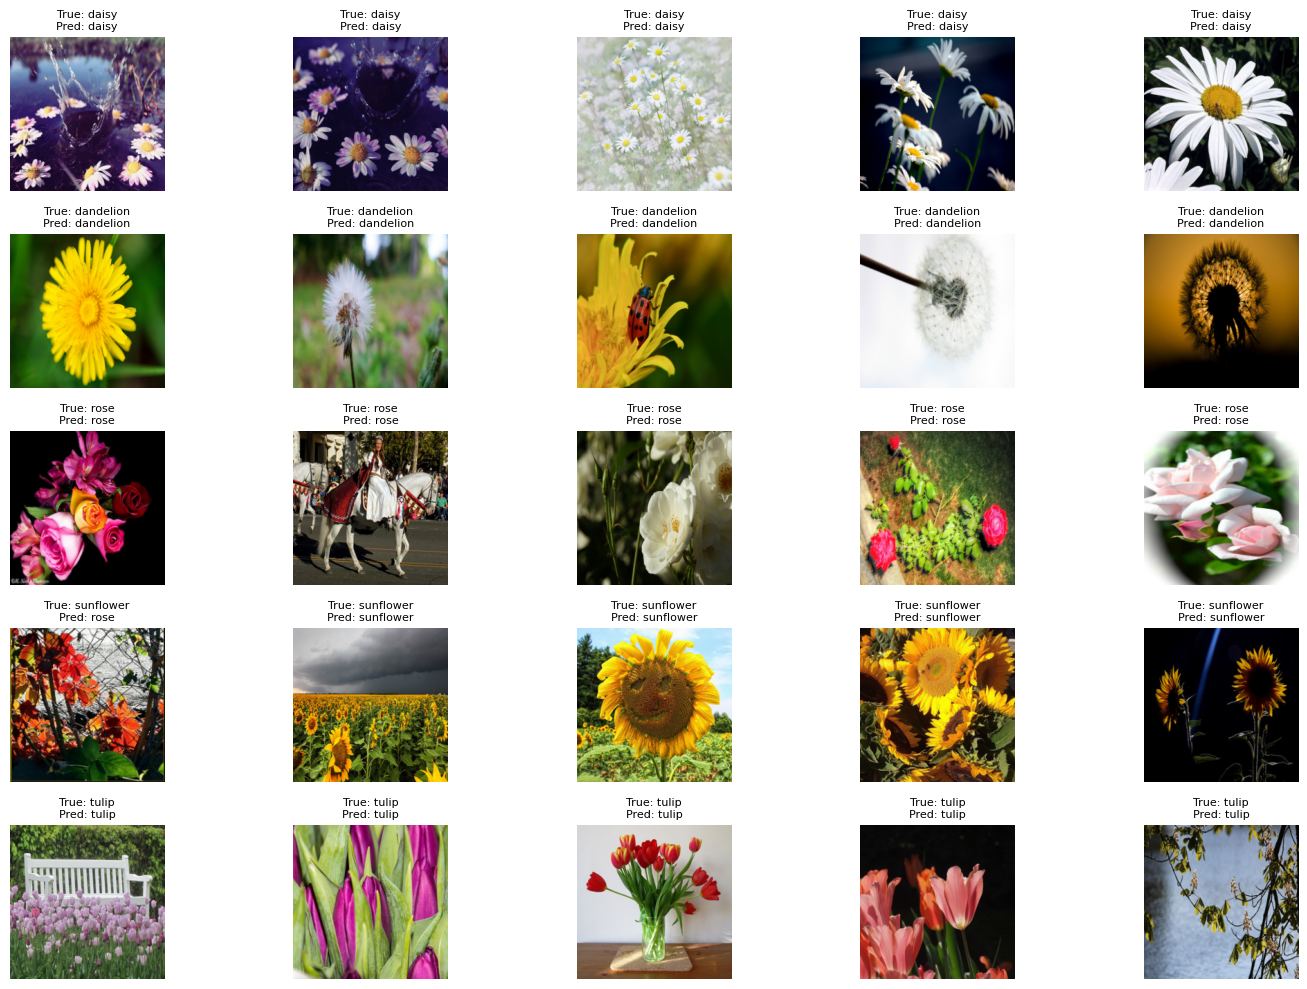

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot images with predictions and true labels
def plot_predictions_per_class(test_loader, model, classes, num_images_per_class=5):
    model.eval()
    images_by_class = {cls: [] for cls in classes}  # Store images for each class
    predictions_by_class = {cls: [] for cls in classes}
    true_labels_by_class = {cls: [] for cls in classes}

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images).logits
            _, predicted = torch.max(outputs, 1)

            for img, true_label, pred_label in zip(images, labels, predicted):
                true_class = classes[true_label.item()]
                pred_class = classes[pred_label.item()]

                if len(images_by_class[true_class]) < num_images_per_class:
                    images_by_class[true_class].append(img.cpu())
                    true_labels_by_class[true_class].append(true_class)
                    predictions_by_class[true_class].append(pred_class)

    # Plotting
    fig, axes = plt.subplots(len(classes), num_images_per_class, figsize=(15, 10))
    for i, cls in enumerate(classes):
        for j in range(num_images_per_class):
            if j < len(images_by_class[cls]):
                img = images_by_class[cls][j]
                true_label = true_labels_by_class[cls][j]
                pred_label = predictions_by_class[cls][j]

                img = img.permute(1, 2, 0).numpy()  # Convert to HWC format
                img = (img * 0.5) + 0.5  # Denormalize

                axes[i, j].imshow(img)
                axes[i, j].axis("off")
                axes[i, j].set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=8)
            else:
                axes[i, j].axis("off")  # Hide empty plots
    plt.tight_layout()
    plt.show()

# Plot predictions
plot_predictions_per_class(test_loader, model, train_dataset.classes, num_images_per_class=5)
